# Using CNN for detection on one-minute files

Aim is to run the pre-trained CNN on 'real' one-minute test files, to see how it performs.

Of course I haven't done any hard negative mining or anything like that yet so there is a lot of things to do...

In [224]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import numpy as np
import scipy.io
import cPickle as pickle

from scipy.ndimage.interpolation import zoom
from time import time

sys.path.append(os.path.expanduser('~/projects/engaged_hackathon/'))
from engaged.features import features, evaluation

from nolearn.lasagne import objective
from lasagne.layers import get_all_params

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

## Loading in train and test split

We only want to run the CNN on files from the test split

In [225]:
savedir = '/home/michael/projects/engaged_hackathon_data/detection/train_test_patches/'
split = scipy.io.loadmat(savedir + 'split.mat')
split['test_files'] = [xx.strip() for xx in split['test_files']]

## Analyse the distribution of biotic sounds in ground truth

i.e. how much biotic sound even is there in the test dataset?

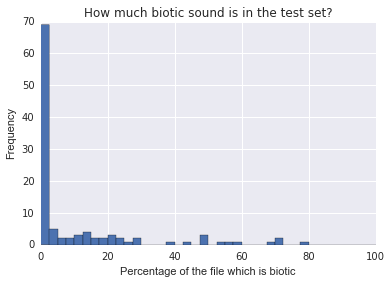

In [226]:
# for each test file, load in the ground truth and see what percentage is actually biotic
has_biotic = []  # list of files which have biotic 
percentages = []  # list of percentages
for fname in split['test_files']:
    
    # load in the ground truth labelling and see how much biotic sound there is
    gt = scipy.io.loadmat(base_path + '/detection_challenge/' + fname + '.mat')
    percentages.append(gt['biotic'].mean() * 100)
    
    # keep track of which files have a 'lot' of biotic noise
    if gt['biotic'].mean() > 0.1:
        has_biotic.append(fname)
    
plt.hist(percentages, np.linspace(0, 100, 41))
plt.xlabel('Percentage of the file which is biotic')
plt.ylabel('Frequency')
plt.title('How much biotic sound is in the test set?');

## Load one file and show the spectrogram and ground truth

CR05EF-13527_20130921_1236
(128, 1496)


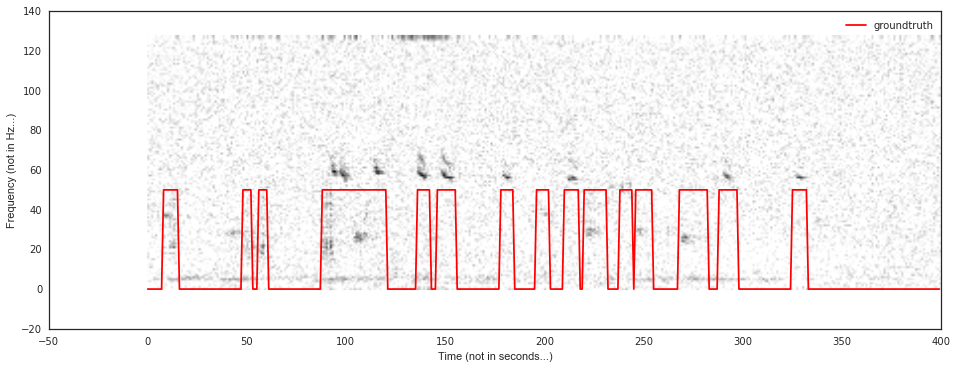

In [239]:
# Just do one file for now. Load in spectrogram...
fname = has_biotic[0]
print fname

base_path = '/home/michael/projects/engaged_hackathon_data/raw_data/one_minute_files'
spec_path = '/home/michael/projects/engaged_hackathon_data/detection/spectrograms/'

# load in spec and also the gt labels
spec = scipy.io.loadmat(spec_path + fname + '_spec_128.mat')['spectrogram']
print spec.shape
# smallspec = scipy.io.loadmat(spec_path + fname + '_smallspec.mat')['spectrogram']
gt = scipy.io.loadmat(base_path + '/detection_challenge/' + fname + '.mat')
    
# convert the labels to the sampling rate of the spectrogram
zoom_factor = float(spec.shape[1]) / float(gt['biotic'][0].shape[0])
gt_biotic = zoom(gt['biotic'][0], zoom_factor).astype(float)

plt.figure(figsize=(16, 10))
with sns.axes_style("white"):
    plt.imshow(spec[:, :400], cmap=plt.get_cmap('gray_r'))
plt.plot(gt_biotic[:400] * 50, 'r', label='groundtruth')
plt.gca().invert_yaxis()
# plt.xlim(0, 400)
# plt.ylim(0, 75)
plt.legend()
plt.xlabel('Time (not in seconds...)')
plt.ylabel('Frequency (not in Hz...)');

## Load in the pre-trained CNN

In [148]:
# I need to redefine this reg objective due to the 
# pickling, will see if I can avoid doing this...
def regularization_objective(layers, lambda1=0., lambda2=0., *args, **kwargs):
    # default loss
    losses = objective(layers, *args, **kwargs)
    # get the layers' weights, but only those that should be regularized
    # (i.e. not the biases)
    weights = get_all_params(layers[-1], regularizable=True)
    # sum of absolute weights for L1
    sum_abs_weights = sum([abs(w).sum() for w in weights])
    # sum of squared weights for L2
    sum_squared_weights = sum([(w ** 2).sum() for w in weights])
    # add weights to regular loss
    losses += lambda1 * sum_abs_weights + lambda2 * sum_squared_weights
    return losses

modeldir = '/home/michael/projects/engaged_hackathon_data/detection/models/'
net = pickle.load(open(modeldir + 'cnn_' + 'full' + '.pkl'))

## Extract patches from the test file and classify

In [196]:
patches = features.extract_1d_patches(spec, range(spec.shape[1]), 9)
S = patches.shape
patches = patches.reshape((S[0], 1, S[1], S[2])).astype(np.float32)

print patches.shape

# apply the model to the single test file
pred_y = net.predict_proba(patches)[:, 1]

(876, 1, 75, 19)


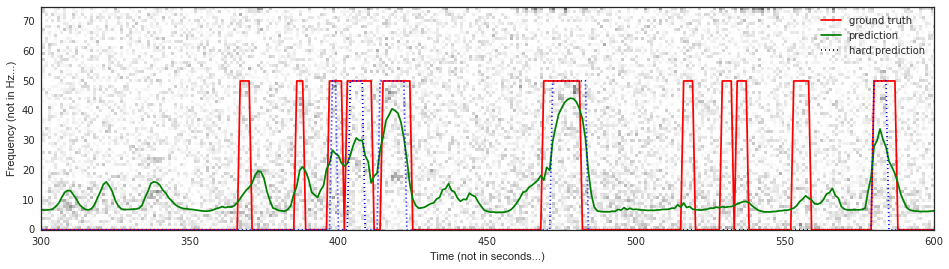

In [223]:
plt.figure(figsize=(16, 10))

t_start, t_end = 500, 600

with sns.axes_style('white'):
    plt.imshow(spec, cmap=plt.get_cmap('gray_r'), interpolation='nearest')
plt.plot(gt_biotic * 50, 'r', label='ground truth')
plt.plot(pred_y * 50, 'g', label='prediction')
plt.plot((pred_y>0.5) * 50, 'b:', label='hard prediction')
plt.gca().invert_yaxis()
plt.xlim(300, 600)
plt.ylim(0, 75)
plt.xlabel('Time (not in seconds...)')
plt.ylabel('Frequency (not in Hz...)');
plt.legend(loc='best');

### Biotic sounds

In [214]:
import scipy.io.wavfile
import IPython
wav_base_path = '/home/michael/projects/engaged_hackathon_data/raw_data/one_minute_files'
sr, wav = scipy.io.wavfile.read(wav_base_path + '/25_Random/' + fname + '.wav')

# snip up to find the predictions
factor = wav.shape[0] / float(pred_y.shape[0])
pred_y_rescaled = zoom(pred_y, factor)

biotic_wav = wav[pred_y_rescaled > 0.5]
scipy.io.wavfile.write('/home/michael/Dropbox/engage/biotic.wav', sr, biotic_wav)
IPython.display.Audio(data=biotic_wav, rate=sr)

### Non biotic sounds

In [215]:
non_biotic_wav = wav[pred_y_rescaled < 0.5]
scipy.io.wavfile.write('/home/michael/Dropbox/engage/non_biotic.wav', sr, non_biotic_wav)
IPython.display.Audio(data=non_biotic_wav, rate=sr)

### Accuracies on this one file

In [180]:
print accuracy_score(gt_biotic, pred_y>0.5)

# do normalised accuracy...
def norm_acc(gt, pred):
    if (gt==0).sum() > 0:
        a = 1.0 - pred[gt==0].mean()
    else:
        a = 1.0
        
    if (gt==1).sum() > 0:
        b = pred[gt==1].mean()
    else:
        b = 1.0
    return (a + b)/2

print norm_acc(gt_biotic, pred_y)
print norm_acc(gt_biotic, pred_y>0.5)

0.83904109589
0.700878046453
0.785872930408


In [181]:
conf = confusion_matrix(gt_biotic, pred_y>0.5)
print conf
sns.set_style("darkgrid")

[[580  66]
 [ 75 155]]


## Evaluate accuracy over all the test files 

In [182]:
# now do for each possible test file:
accs = []
norm_accs = []
lens = []

for count, fname in enumerate(split['test_files']):

    # load the spec and gt
    spec = scipy.io.loadmat(spec_path + fname + '_smallspec.mat')['spectrogram']
    gt = scipy.io.loadmat(base_path + '/detection_challenge/' + fname + '.mat')

    # convert the labels to the sampling rate of the spectrogram
    zoom_factor = float(spec.shape[1]) / float(gt['biotic'][0].shape[0])
    gt_biotic = zoom(gt['biotic'][0], zoom_factor).astype(float)

    # extracting the patches
    patches = features.extract_1d_patches(spec, range(spec.shape[1]), 9)
    S = patches.shape
    patches = patches.reshape((S[0], 1, S[1], S[2])).astype(np.float32)

    #  classify
    pred_y = net.predict_proba(patches)[:, 1]
    
    accs.append(accuracy_score(gt_biotic, pred_y>0.5))
    norm_accs.append(norm_acc(gt_biotic, pred_y>0.5))
    lens.append(evaluation.eval_seconds(gt_biotic, pred_y, 60.0))
    
    print count,

15.7534246575
20.896092245
15.1369863014


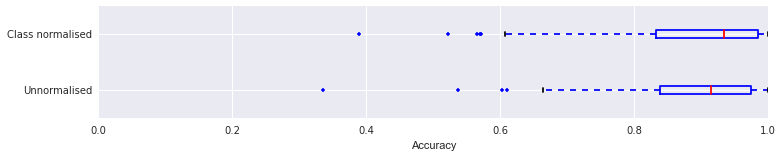

In [189]:
plt.figure(figsize=(12, 2))
plt.boxplot([accs, norm_accs], 0, 'b.', 0);
plt.gca().set_yticklabels(['Unnormalised', 'Class normalised'])
plt.xlim(0, 1)
plt.xlabel('Accuracy')

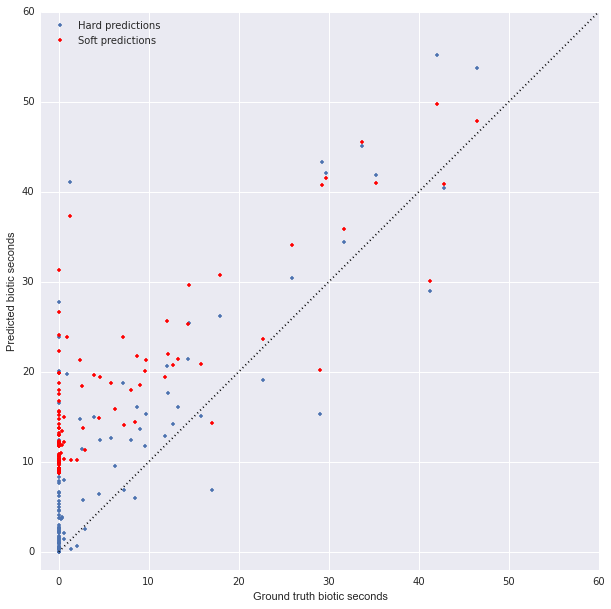

In [188]:
bi_s = np.array([l['biotic'] for l in lens])
pred_s = np.array([l['predicted'] for l in lens])
pred_hard_s = np.array([l['predicted_hard'] for l in lens])

plt.figure(figsize=(10, 10))

plt.plot(bi_s, pred_hard_s, '.', label='Hard predictions')
plt.plot(bi_s, pred_s, '.r', label='Soft predictions')
plt.xlabel('Ground truth biotic seconds')
plt.ylabel('Predicted biotic seconds')
plt.xlim(-2, 60)
plt.ylim(-2, 60)
plt.gca().set_aspect('equal', adjustable='box')
plt.plot([0, 60], [0, 60], 'k:')
plt.legend(loc='best')